# San Francisco Public Library patron dataset 

Github: https://github.com/josiechoi/Ryerson_capstone_library_usage/blob/master/Capstone%20Initial%20Coding%20and%20Results%20-class%20imbalance.ipynb
Data Source: https://data.sfgov.org/Culture-and-Recreation/Library-Usage/qzz6-2jup

In [1]:
# this will only work if you first 'conda install geopandas' through Anaconda prompt. pip install works too. Require to run Anaconda prompt as administrator (that's right click at Anaconda prompt )
import geopandas as gpd
import descartes

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
%matplotlib inline

In [3]:
#'conda install -c conda-forge imbalanced-learn'

In [4]:

# check version number
import imblearn
print(imblearn.__version__)


0.6.2


## Dataset

Dataset is loaded. Here's the initial inspection of the head (with first few rows), description, and info that would indicate data types

In [5]:
df=pd.read_csv("data/Library_Usage.csv")



# Initial Cleanup
That include removable variables with less values, such as 'Circulation Active Month'

We are also going to combine Total Checkouts and Total Renewals to create total_cko, as these are both circulation activities. And then, we are going to calculate the year_registered and average cko, since it is important to take number of years a patron has an account before evaluating the usage. 

In sum, three new variables will be created here, and one will be dropped

To be created:
- total_cko
- avg_cko
- years_registered

To be dropped
- Circulation Active Month



In [6]:
df=df.drop('Circulation Active Month', axis=1)
df['total_cko']=df['Total Checkouts']+df['Total Renewals']
df['years_registered']=2016-df['Year Patron Registered']
df['avg_cko']=df['total_cko']/(2016-df['Year Patron Registered'])
df['avg_cko'].loc[df['Year Patron Registered']==2016]=df['total_cko']


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [7]:
# inspection data after the initial clean-up
df.head()

,Patron Type Code,Patron Type Definition,Total Checkouts,Total Renewals,Age Range,Home Library Code,Home Library Definition,Circulation Active Year,Notice Preference Code,Notice Preference Definition,Provided Email Address,Year Patron Registered,Outside of County,Supervisor District,total_cko,years_registered,avg_cko
0,0,ADULT,1092,761,60 to 64 years,M6,Mission,2016,p,phone,False,2003,False,9.0,1853,13,142.538462
1,0,ADULT,0,0,20 to 24 years,P1,Park,None,z,email,True,2014,False,5.0,0,2,0.000000
2,0,ADULT,31,22,25 to 34 years,S7,Sunset,2016,z,email,True,2010,False,4.0,53,6,8.833333
3,0,ADULT,0,0,45 to 54 years,P1,Park,None,a,print,False,2016,True,NaN,0,0,0.000000
4,0,ADULT,0,0,25 to 34 years,X,Main Library,None,z,email,True,2015,False,3.0,0,1,0.000000


In [8]:

df['age_med']=39.5
df['age_med'].loc[df['Age Range']=="0 to 9 years"]=4.5
df['age_med'].loc[df['Age Range']=="10 to 19 years"]=14.5
df['age_med'].loc[df['Age Range']=="20 to 24 years"]=22
df['age_med'].loc[df['Age Range']=="25 to 34 years"]=29.5
df['age_med'].loc[df['Age Range']=="35 to 44 years"]=39.5
df['age_med'].loc[df['Age Range']=="45 to 54 years"]=49.5
df['age_med'].loc[df['Age Range']=="55 to 59 years"]=57
df['age_med'].loc[df['Age Range']=="60 to 64 years"]=62
df['age_med'].loc[df['Age Range']=="65 to 74 years"]=69.5
df['age_med'].loc[df['Age Range']=="0 to 9 years"]=77


In [9]:
df['user_category']='Infrequent'
df['user_category'].loc[df['avg_cko']>50]='Frequent'

In [10]:
df.describe()


col=['Patron Type Code', 'Supervisor District','avg_cko','years_registered']

In [11]:
df['email']=1
df['email'].loc[df['Provided Email Address']==False]=0

In [12]:
df['has_supdist'] = ~df['Supervisor District'].isnull()

In [13]:
df['outside_county']=1
df['outside_county'].loc[df['Outside of County']==False]=0

Create the label "Frequent" and "Infrequent" to use, so that we can test on using this dataset for prediction
"Frequent" is defined as user with 50 times average circulation activities (avg_cko). 
Below are various countplots to explore the relationship between this new variable ("user_category") and the existing variables. Nothing jump out when inspecting these plots. 

Median seems to be the most meaningful variables here, so we are plotting it with a bigger figsize. The red dot denoted the location of different branches. 
The other varaibles are also plotted below

In [14]:
df['frequency']=0
df['frequency'].loc[df['avg_cko']>50]=1


In [15]:
print(df['frequency'].sum())
df.describe()

65522


,Patron Type Code,Total Checkouts,Total Renewals,Year Patron Registered,Supervisor District,total_cko,years_registered,avg_cko,age_med,email,outside_county,frequency
count,423448.000000,423448.000000,423448.000000,423448.000000,313138.000000,423448.000000,423448.000000,423448.000000,423448.000000,423448.000000,423448.000000,423448.000000
mean,1.036765,161.982097,59.657327,2010.348917,6.288240,221.639424,5.651083,29.444586,41.330219,0.794478,0.150715,0.154734
std,4.188198,453.703678,225.009917,4.357374,3.123634,613.848408,4.357374,67.819603,19.213773,0.404083,0.357771,0.361652
min,0.000000,0.000000,0.000000,2003.000000,1.000000,0.000000,0.000000,0.000000,14.500000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,2007.000000,4.000000,3.000000,2.000000,1.000000,29.500000,1.000000,0.000000,0.000000
50%,0.000000,19.000000,2.000000,2012.000000,6.000000,26.000000,4.000000,6.000000,39.500000,1.000000,0.000000,0.000000
75%,1.000000,113.000000,27.000000,2014.000000,9.000000,154.000000,9.000000,26.142857,57.000000,1.000000,0.000000,0.000000
max,104.000000,35907.000000,8965.000000,2016.000000,11.000000,36023.000000,13.000000,2771.000000,77.000000,1.000000,1.000000,1.000000


In [16]:
print(65522/423448)

0.15473446562505905


In [17]:
df['Patron Type Definition']=df['Patron Type Definition'].replace("AT USER ADULT","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("AT USER JUVENILE","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("AT USER SENIOR","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("AT USER WELCOME","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("AT USER TEEN","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("AT USER TEEN","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("FRIENDS FOR LIFE","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("DIGITAL ACCESS CARD","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("RETIRED STAFF","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("VISITOR","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("BOOK BY MAIL","OTHER")
df['Patron Type Definition']=df['Patron Type Definition'].replace("SPECIAL","OTHER")


C:\ProgramData\Anaconda3\lib\site-packages\seaborn\categorical.py:3666: UserWarning: The `factorplot` function has been renamed to `catplot`. The original name will be removed in a future release. Please update your code. Note that the default `kind` in `factorplot` (`'point'`) has changed `'strip'` in `catplot`.
  warnings.warn(msg)


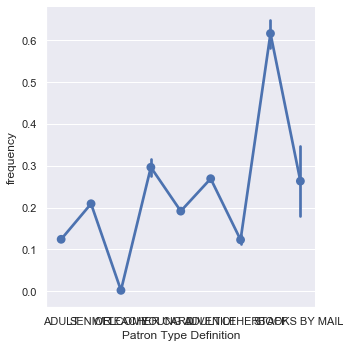

In [18]:

sns.set(rc={'figure.figsize':(15.8,12.27)})
sns.factorplot(x="Patron Type Definition", y="frequency", data=df);

In [19]:
df.describe()

,Patron Type Code,Total Checkouts,Total Renewals,Year Patron Registered,Supervisor District,total_cko,years_registered,avg_cko,age_med,email,outside_county,frequency
count,423448.000000,423448.000000,423448.000000,423448.000000,313138.000000,423448.000000,423448.000000,423448.000000,423448.000000,423448.000000,423448.000000,423448.000000
mean,1.036765,161.982097,59.657327,2010.348917,6.288240,221.639424,5.651083,29.444586,41.330219,0.794478,0.150715,0.154734
std,4.188198,453.703678,225.009917,4.357374,3.123634,613.848408,4.357374,67.819603,19.213773,0.404083,0.357771,0.361652
min,0.000000,0.000000,0.000000,2003.000000,1.000000,0.000000,0.000000,0.000000,14.500000,0.000000,0.000000,0.000000
25%,0.000000,2.000000,0.000000,2007.000000,4.000000,3.000000,2.000000,1.000000,29.500000,1.000000,0.000000,0.000000
50%,0.000000,19.000000,2.000000,2012.000000,6.000000,26.000000,4.000000,6.000000,39.500000,1.000000,0.000000,0.000000
75%,1.000000,113.000000,27.000000,2014.000000,9.000000,154.000000,9.000000,26.142857,57.000000,1.000000,0.000000,0.000000
max,104.000000,35907.000000,8965.000000,2016.000000,11.000000,36023.000000,13.000000,2771.000000,77.000000,1.000000,1.000000,1.000000


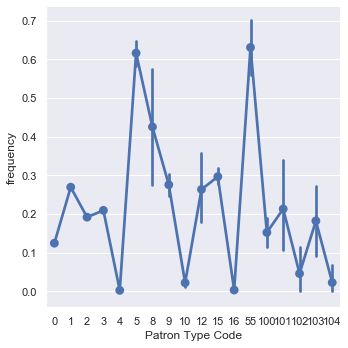

In [20]:

sns.set(rc={'figure.figsize':(15.8,12.27)})
sns.factorplot(x="Patron Type Code", y="frequency", data=df);

In [21]:
df['Home Library Definition']=df['Home Library Definition'].replace("Branch Bookmobile (Excelsior)","Bookmobile")
df['Home Library Definition']=df['Home Library Definition'].replace("Branch Bookmobile (Marina)","Bookmobile")
df['Home Library Definition']=df['Home Library Definition'].replace("Branch Bookmobile (Sunset)","Bookmobile")
df['Home Library Definition']=df['Home Library Definition'].replace("Branch Bookmobile (West Portal)","Bookmobile")
df['Home Library Definition']=df['Home Library Definition'].replace("Children's Bookmobile","Bookmobile")

In [22]:
df.corr()["frequency"]

Patron Type Code          0.018951
Total Checkouts           0.594655
Total Renewals            0.459589
Provided Email Address   -0.005070
Year Patron Registered   -0.208094
Outside of County        -0.097084
Supervisor District      -0.039049
total_cko                 0.607983
years_registered          0.208094
avg_cko                   0.702176
age_med                   0.089258
email                    -0.005070
has_supdist               0.081943
outside_county           -0.097084
frequency                 1.000000
Name: frequency, dtype: float64

In [23]:
df.drop(['Patron Type Definition', 'Total Checkouts', 'Total Renewals', 'Age Range','Circulation Active Year','Notice Preference Code','Notice Preference Definition','Provided Email Address','Year Patron Registered','Outside of County'], axis=1, inplace=True)

In [24]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 423448 entries, 0 to 423447
Data columns (total 13 columns):
Patron Type Code           423448 non-null int64
Home Library Code          423408 non-null object
Home Library Definition    423448 non-null object
Supervisor District        313138 non-null float64
total_cko                  423448 non-null int64
years_registered           423448 non-null int64
avg_cko                    423448 non-null float64
age_med                    423448 non-null float64
user_category              423448 non-null object
email                      423448 non-null int64
has_supdist                423448 non-null bool
outside_county             423448 non-null int64
frequency                  423448 non-null int64
dtypes: bool(1), float64(3), int64(6), object(3)
memory usage: 39.2+ MB


In [25]:
df.head()

,Patron Type Code,Home Library Code,Home Library Definition,Supervisor District,total_cko,years_registered,avg_cko,age_med,user_category,email,has_supdist,outside_county,frequency
0,0,M6,Mission,9.0,1853,13,142.538462,62.0,Frequent,0,True,0,1
1,0,P1,Park,5.0,0,2,0.000000,22.0,Infrequent,1,True,0,0
2,0,S7,Sunset,4.0,53,6,8.833333,29.5,Infrequent,1,True,0,0
3,0,P1,Park,NaN,0,0,0.000000,49.5,Infrequent,0,False,1,0
4,0,X,Main Library,3.0,0,1,0.000000,29.5,Infrequent,1,True,0,0


In [26]:
df['Supervisor District'] = df['Supervisor District'].fillna(12)

In [27]:
data_dum = pd.get_dummies(df, drop_first=True)
data_dum.head()

,Patron Type Code,Supervisor District,total_cko,years_registered,avg_cko,age_med,email,has_supdist,outside_county,frequency,...,Home Library Definition_Portola,Home Library Definition_Potrero,Home Library Definition_Presidio,Home Library Definition_Richmond,Home Library Definition_Sunset,Home Library Definition_Unknown,Home Library Definition_Visitacion Valley,Home Library Definition_West Portal,Home Library Definition_Western Addition,user_category_Infrequent
0,0,9.0,1853,13,142.538462,62.0,0,True,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,5.0,0,2,0.000000,22.0,1,True,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,4.0,53,6,8.833333,29.5,1,True,0,0,...,0,0,0,0,1,0,0,0,0,1
3,0,12.0,0,0,0.000000,49.5,0,False,1,0,...,0,0,0,0,0,0,0,0,0,1
4,0,3.0,0,1,0.000000,29.5,1,True,0,0,...,0,0,0,0,0,0,0,0,0,1


In [28]:
#import numpy as np
#from sklearn.model_selection import train_test_split
# Imports
#import pandas as pd
#import matplotlib.pyplot as plt
#import seaborn as sns
#import re

#from sklearn import tree
#from sklearn.model_selection import GridSearchCV


In [29]:
y=data_dum['frequency']
X=data_dum.drop(['frequency','user_category_Infrequent','total_cko','avg_cko'],axis=1)

In [30]:
X.head()

,Patron Type Code,Supervisor District,years_registered,age_med,email,has_supdist,outside_county,Home Library Code_AQUIS,Home Library Code_B2,Home Library Code_B2AAA,...,Home Library Definition_Parkside,Home Library Definition_Portola,Home Library Definition_Potrero,Home Library Definition_Presidio,Home Library Definition_Richmond,Home Library Definition_Sunset,Home Library Definition_Unknown,Home Library Definition_Visitacion Valley,Home Library Definition_West Portal,Home Library Definition_Western Addition
0,0,9.0,13,62.0,0,True,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,5.0,2,22.0,1,True,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,4.0,6,29.5,1,True,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
3,0,12.0,0,49.5,0,False,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,3.0,1,29.5,1,True,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [31]:

# Oversample and plot imbalanced dataset with SMOTE
from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot
from numpy import where
counter = Counter(y)
print(counter)


Counter({0: 357926, 1: 65522})


In [32]:
oversample = SMOTE()
X, y = oversample.fit_resample(X, y)
# summarize the new class distribution
counter = Counter(y)
print(counter)

Counter({1: 357926, 0: 357926})


In [33]:
# decision tree evaluated on imbalanced dataset
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.tree import DecisionTreeClassifier


# define model
model = DecisionTreeClassifier()
# evaluate pipeline
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(scores))

Mean ROC AUC: 0.820


In [35]:
#Logistic Regression Model 
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(X, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
score2 = cross_val_score(logreg, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(score2))

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


Mean ROC AUC: 0.716


In [36]:
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X, y)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
score3 = cross_val_score(knn, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % mean(score3))

C:\ProgramData\Anaconda3\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


Mean ROC AUC: 0.760


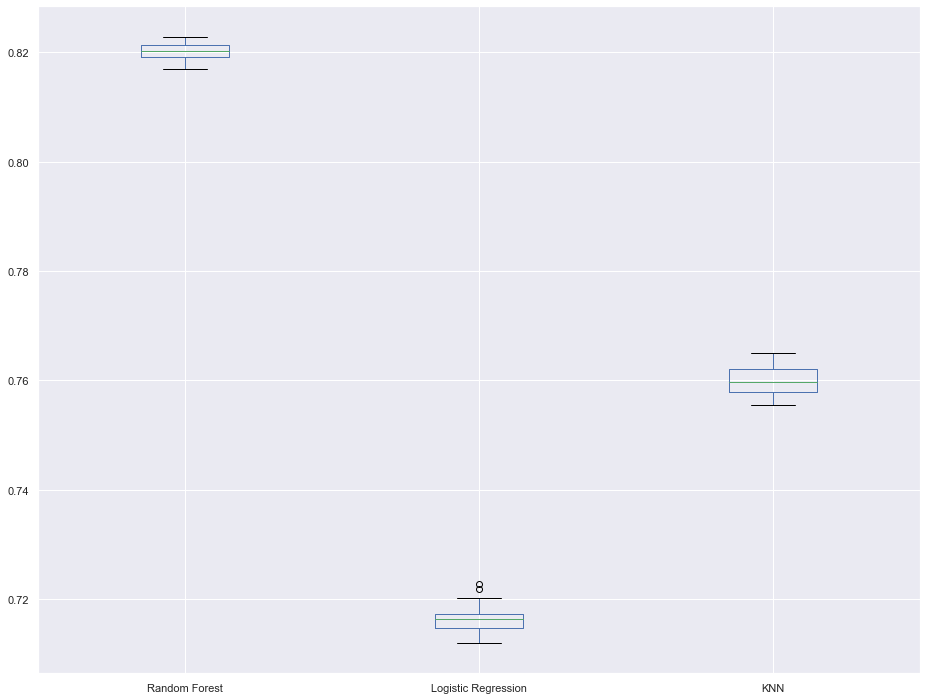

In [42]:


df=pd.DataFrame.from_dict({'Random Forest':scores,'Logistic Regression':score2, 'KNN': score3})

df.head()

boxplot=df.boxplot(column=['Random Forest', 'Logistic Regression', 'KNN'])
